# Intro

### In this notebook, I take the potentially relavent datasets from the world bank including the target of interest (Cereal Yields) and load, merge, transform, filter and impute the data ready for a first model

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('../utils/')
from functions import world_bank_data_load_melt

## Loop through directory of world bank datasets merging to single dataframe

In [186]:
path = '/home/sean/Documentos/the_bridge_bootcamp/My_Workspaces/ML_Project/raw_data/world_bank_data'
df = pd.DataFrame(columns=['Country Name', 'Country Code',  'Year'])

for root, subdirs, files in os.walk(path):
    for file in files:
        if file.startswith('API'):
            df_variable = world_bank_data_load_melt(root + '/' + file)
            df = df.merge(df_variable, how = 'outer')

In [187]:
df.head()

,Country Name,Country Code,Year,Cereal yield (kg per hectare),Investment in transport with private participation (current US$),"Employment in agriculture, male (% of male employment) (modeled ILO estimate)","Employment in agriculture, female (% of female employment) (modeled ILO estimate)",Arable land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)","Renewable internal freshwater resources, total (billion cubic meters)",Arable land (hectares per person),Permanent cropland (% of land area),Energy intensity level of primary energy (MJ/$2017 PPP GDP),"Annual freshwater withdrawals, total (billion cubic meters)",Fertilizer consumption (kilograms per hectare of arable land),"Government expenditure on education, total (% of GDP)","Agricultural machinery, tractors per 100 sq. km of arable land",Total natural resources rents (% of GDP),Agricultural irrigated land (% of total agricultural land)
0,Aruba,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We will dropna for the target column and then assess how many non-null values we have, drop those with too few

In [188]:
df = df.dropna(subset = ['Cereal yield (kg per hectare)'])

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12321 entries, 267 to 16225
Data columns (total 19 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Country Name                                                                       12321 non-null  object 
 1   Country Code                                                                       12321 non-null  object 
 2   Year                                                                               12321 non-null  object 
 3   Cereal yield (kg per hectare)                                                      12321 non-null  float64
 4   Investment in transport with private participation (current US$)                   856 non-null    float64
 5   Employment in agriculture, male (% of male employment) (modeled ILO estimate)      6321 non-null   f

In [190]:
missing_df = pd.DataFrame(df.isnull().sum() * 100 / len(df)).sort_values(by = 0, ascending = False)
missing_df

,0
Investment in transport with private participation (current US$),93.052512
Agricultural irrigated land (% of total agricultural land),92.037984
Energy intensity level of primary energy (MJ/$2017 PPP GDP),71.658145
"Government expenditure on education, total (% of GDP)",56.066878
"Annual freshwater withdrawals, total (billion cubic meters)",53.023294
"Employment in agriculture, male (% of male employment) (modeled ILO estimate)",48.697346
"Employment in agriculture, female (% of female employment) (modeled ILO estimate)",48.697346
"Agricultural machinery, tractors per 100 sq. km of arable land",43.316289
"Agriculture, forestry, and fishing, value added (% of GDP)",25.574223
Total natural resources rents (% of GDP),19.178638


### So we will drop those with > 70% missing which means the 3 variables relating to investment in transport, irrigation and energy intensity of primary energy
### We can keep more missing values on the assumption that using ffill and bfill we can relatively safely fill missing data given the time component - but we must inspect the distribution of missing data so we don't impute values that all come from one end of the time range, i.e. most recent values that are added in as values for 1960's

In [191]:
cols_to_drop = missing_df[missing_df[0] > 70].index

In [192]:
df = df.drop(columns = cols_to_drop)

### Now explore the distributions of the potential variables + target

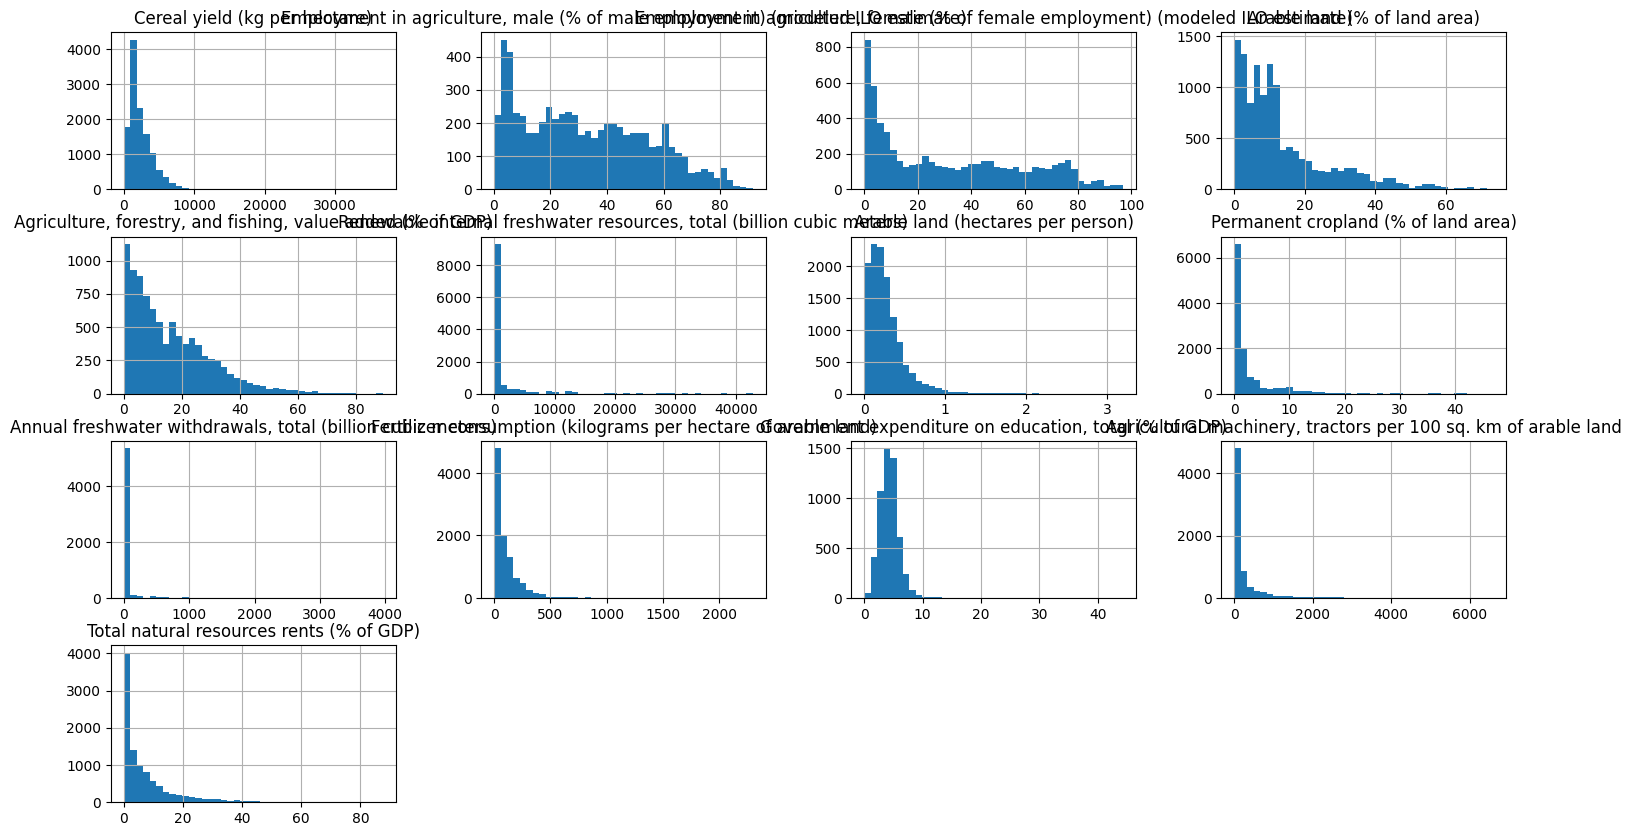

In [193]:
df.hist(bins = 40, figsize = (18, 10));

### All these variables would benifit from a log transformation

In [194]:
log_df = pd.concat([df.select_dtypes(exclude=np.number),
                      df.select_dtypes(include=np.number).apply(np.log1p)],
                      axis=1)

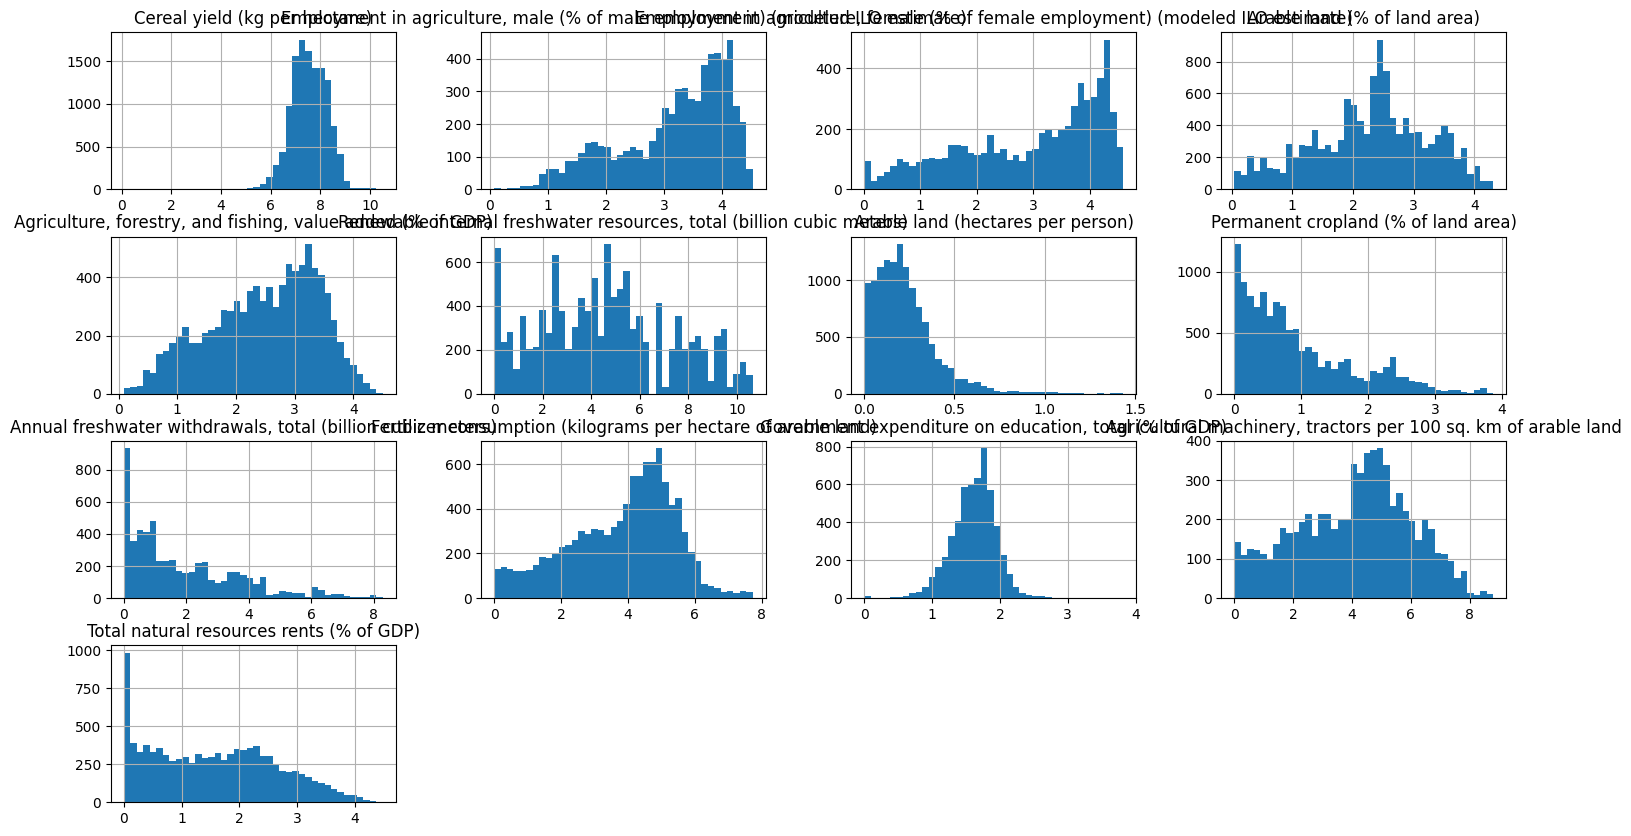

In [195]:
log_df.hist(bins = 40, figsize = (18, 10));

### This has made most variables more 'normal' including, importantly the target
### Now we will inspect the correlations of these variables + target

In [196]:
# the % employmenty for male and female is highly correlated and so we will merge these as an average
log_df['Employment in agriculture, (modeled ILO estimate)'] = log_df[['Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 
                                                              'Employment in agriculture, male (% of male employment) (modeled ILO estimate)']].mean(axis = 1)

log_df = log_df.drop(columns = ['Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 
                                                              'Employment in agriculture, male (% of male employment) (modeled ILO estimate)'])

In [198]:
log_df['Year'] = log_df['Year'].astype('int')

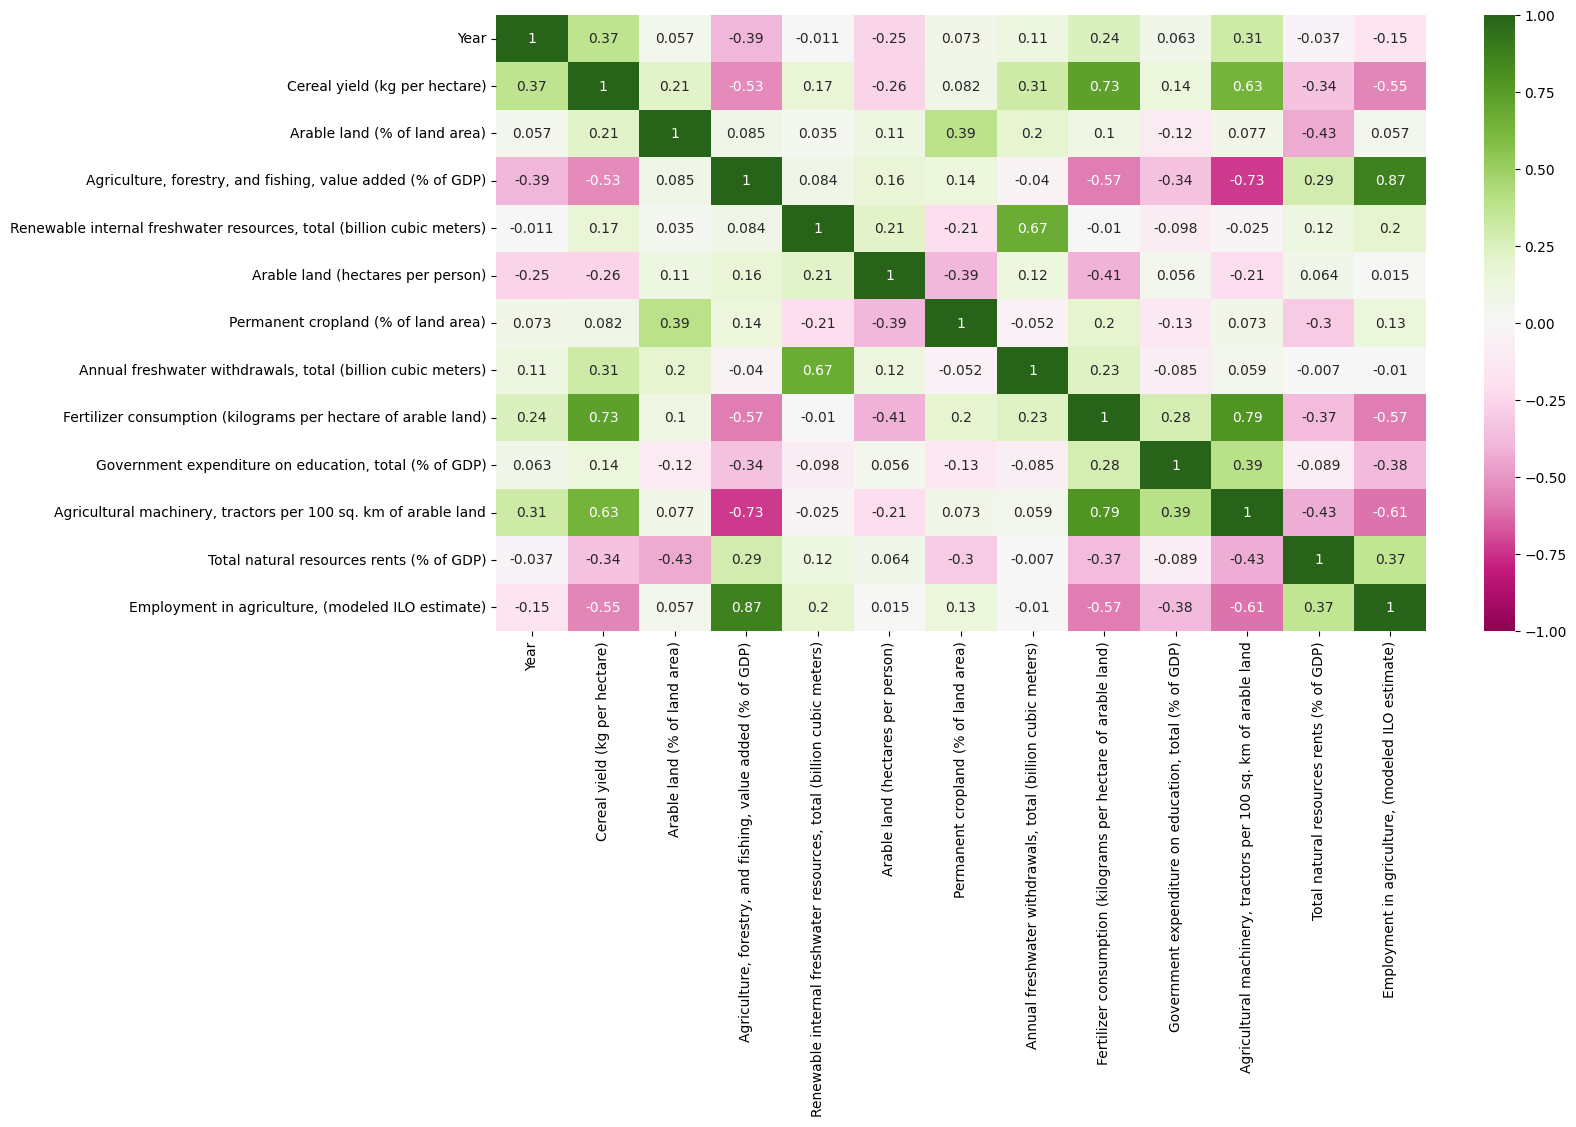

In [199]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(log_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG');

#### We see some strong +ve correlations with agricultural machinery and fertilizer water withdrawls showing a weaker +ve correlation. High correlation between fertlizer and machinery so we could machinery which has more missing values.
#### We see some strong -ve correlations with employment and %GDP for agriculture, forestry, fishing. Both these variables likely relate to the sustained dependence on the rural sectors in the economy as opposed to a shift to higher tech, manufacturing and/or service industry. Countries that have moved away more from the rural economy have become more efficient in it, relying more on machinery, inputs and higher tech options as opposed to low labour costs and a greater level of subsistence agriculture. These two variables are highly correlated and so we will drop the employment variable and keep the %GDP which has fewer missing values
#### Permanent cropland and Renewable internal freshwater resources, total (billion cubic meters) have no/low correlation, so remove them.

In [200]:
log_df = log_df.drop(columns = ['Agricultural machinery, tractors per 100 sq. km of arable land', 
                                'Employment in agriculture, (modeled ILO estimate)', 
                                'Permanent cropland (% of land area)',
                                'Renewable internal freshwater resources, total (billion cubic meters)'])

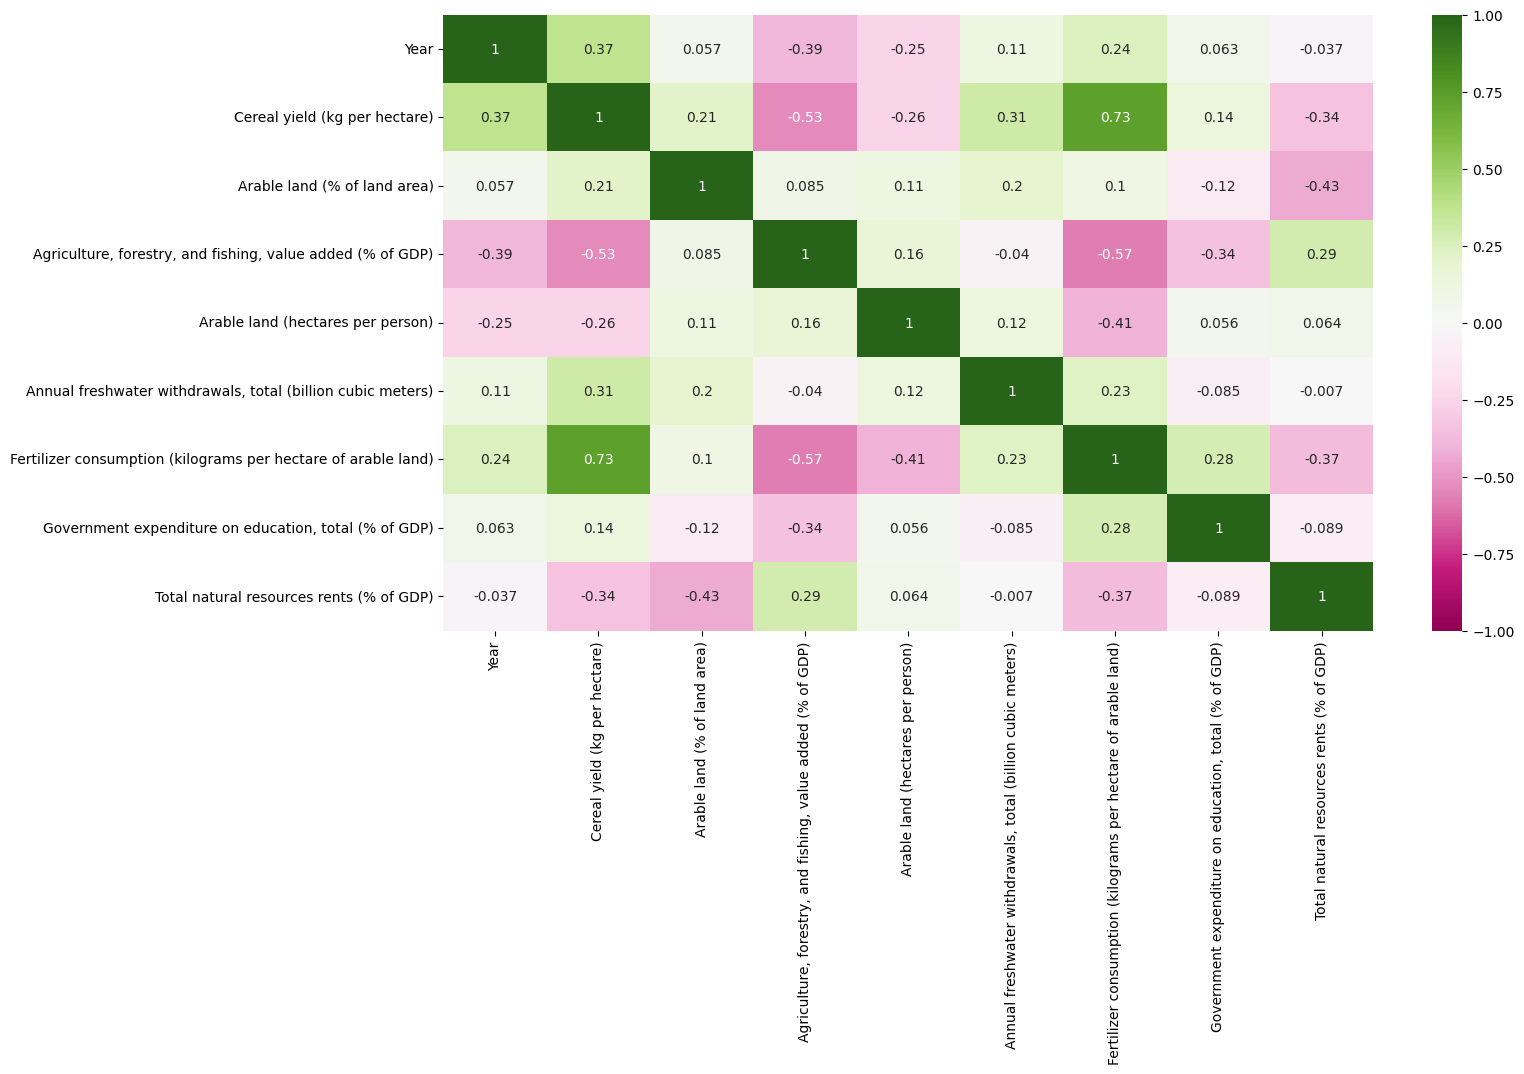

In [201]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(log_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG');

#### So we are left with:
- Year - an expected but not very strong +ve correlation with the cereal yield
- %arable land - this could indicate the overall fertility of a country
- %GDP rural economy - this reflects the general level of development of a country with higher values representing lower development
- Arable land per person - with a higher population per arable land area there is greater pressure on the land to produce and so productivity has increased?
- Freshwater withdrawls - as more water has been extracted, agriculture output has been able to increase being a fundamental input
- fertilizer - this shows a clear link and is a proxy for inputs that drive productivity
- %GDP education - this should have a delayed but at least weak positive impact on productivity leading to greater research
- %GDP natural resources rent - this is another angle on development with countries that rely more on natural resources to support their economy instead of moving through manufacturing and or service industries

# Dealing with missing values and imputing

### We will only keep the countries that have a full time series of yield data to allow trends and delayed effects to be fully modelled

In [202]:
target_count_country = pd.DataFrame(log_df.groupby('Country Name')['Cereal yield (kg per hectare)'].count())

In [203]:
target_count_country['Cereal yield (kg per hectare)'].value_counts()

60    182
29     19
30      8
28      4
21      2
57      2
15      2
9       2
55      1
40      1
6       1
53      1
50      1
19      1
44      1
27      1
Name: Cereal yield (kg per hectare), dtype: int64

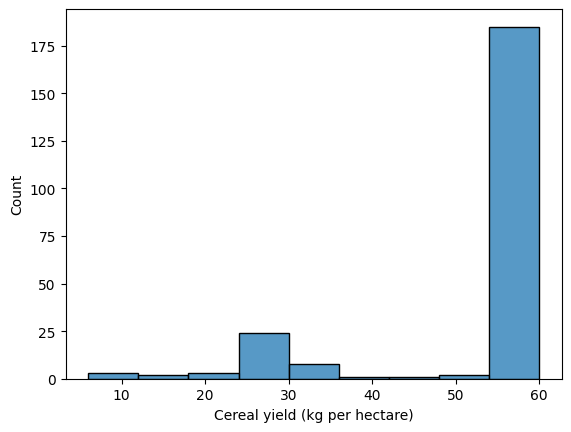

In [204]:
sns.histplot(data = target_count_country, x = 'Cereal yield (kg per hectare)');

#### We will only keep the countries that have a full time series of yield data to allow trends and delayed effects to be fully modelled

In [205]:
log_df = log_df[log_df['Country Name'].isin(target_count_country[target_count_country['Cereal yield (kg per hectare)'] == 60].index)]

### We need to see the distribution of missing values once we sort for Year in order to understand how well bfill or ffill will work

In [206]:
import missingno as msno

In [207]:
log_df = log_df.sort_values(by = 'Year')

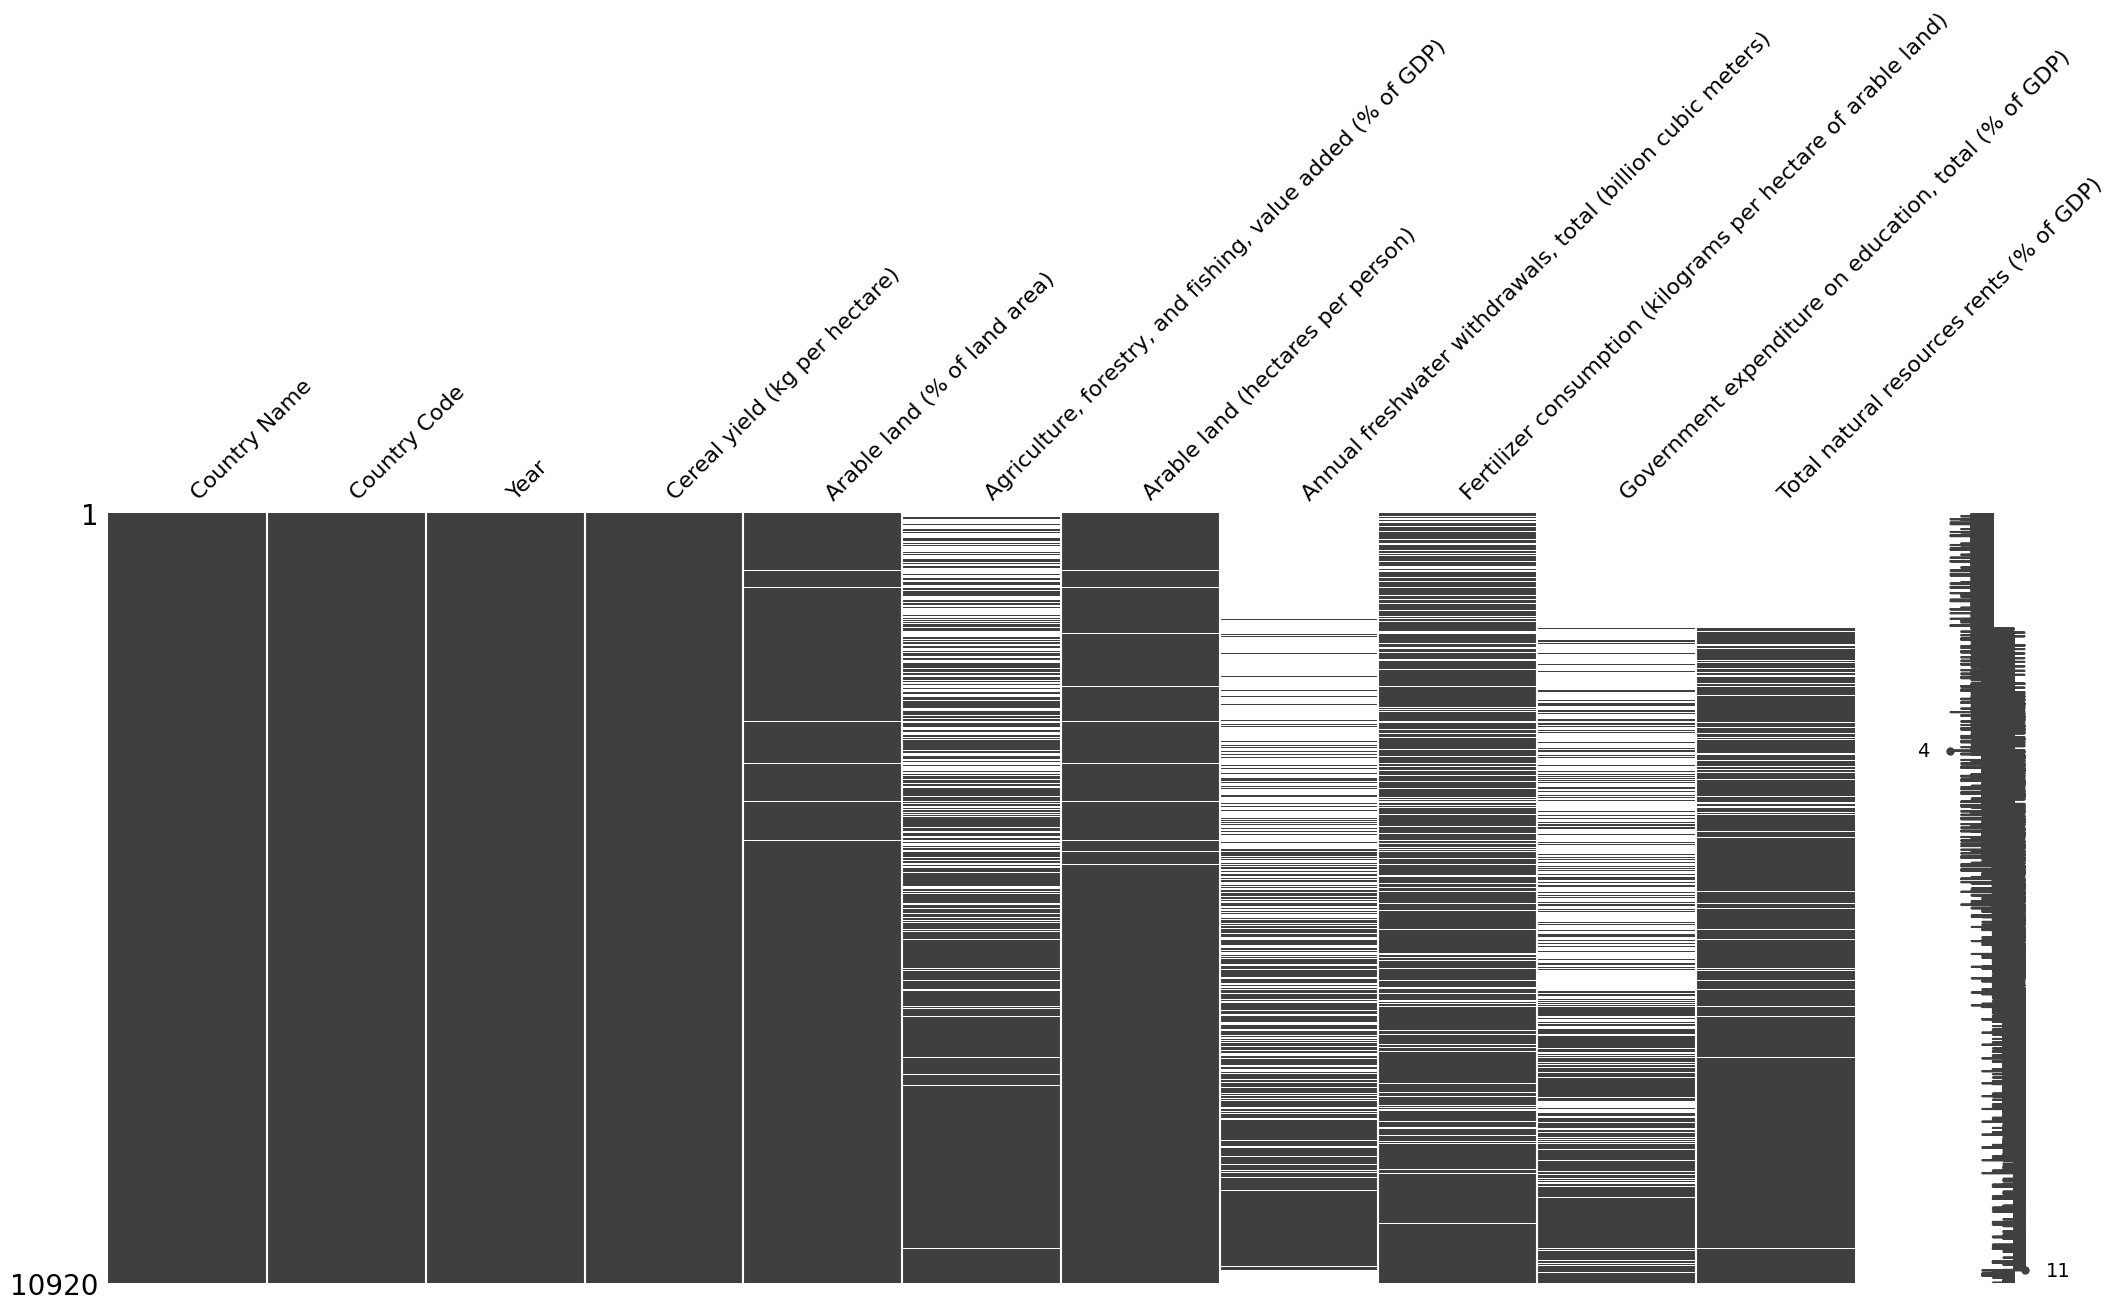

In [208]:
msno.matrix(log_df);

#### It's clear that the missing data is most concentrated in the 1960's. So we will find the first date of the %GDP total natural resources variable and use this to drop all dates before

In [209]:
data_cutoff = log_df['Year'][~log_df['Total natural resources rents (% of GDP)'].isna()].min()

In [210]:
log_df = log_df[log_df['Year'] > data_cutoff]

In [211]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 3103 to 16225
Data columns (total 11 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Country Name                                                   9100 non-null   object 
 1   Country Code                                                   9100 non-null   object 
 2   Year                                                           9100 non-null   int64  
 3   Cereal yield (kg per hectare)                                  9100 non-null   float64
 4   Arable land (% of land area)                                   9023 non-null   float64
 5   Agriculture, forestry, and fishing, value added (% of GDP)     7357 non-null   float64
 6   Arable land (hectares per person)                              8996 non-null   float64
 7   Annual freshwater withdrawals, total (billion cubic mete

#### Now check the percent missing values again

In [212]:
pd.DataFrame(log_df.isnull().sum() * 100 / len(log_df)).sort_values(by = 0, ascending = False)

,0
"Government expenditure on education, total (% of GDP)",49.593407
"Annual freshwater withdrawals, total (billion cubic meters)",47.208791
"Agriculture, forestry, and fishing, value added (% of GDP)",19.153846
Fertilizer consumption (kilograms per hectare of arable land),15.351648
Total natural resources rents (% of GDP),6.428571
Arable land (hectares per person),1.142857
Arable land (% of land area),0.846154
Country Name,0.000000
Country Code,0.000000
Year,0.000000


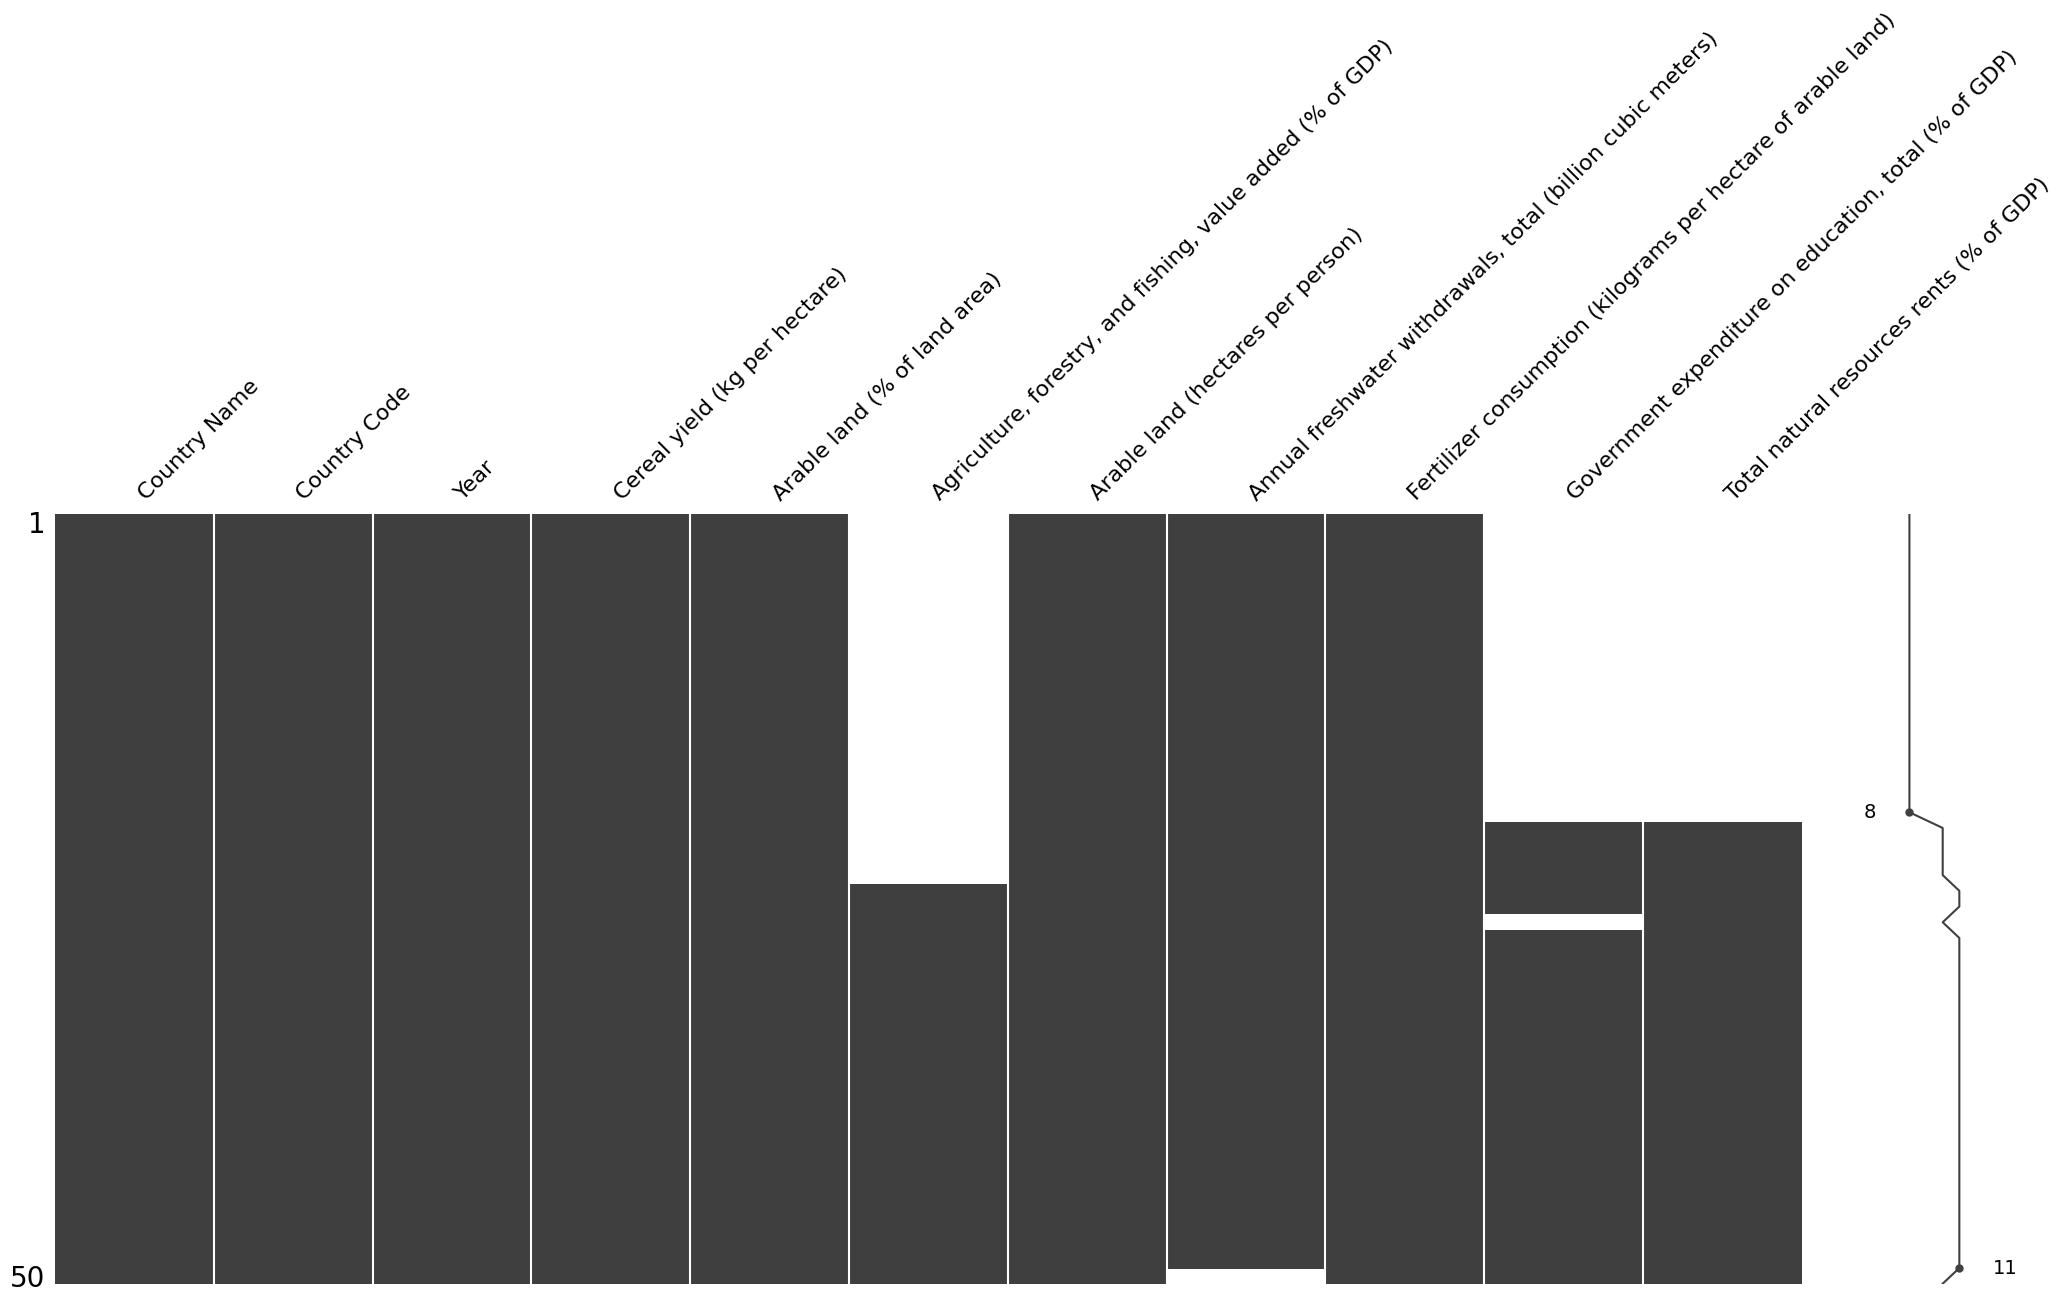

In [108]:
msno.matrix(log_df[log_df['Country Name'] == 'Hungary']);

#### There are still very large blocks of missing data for any given country with greatest concentration further back in time
#### We can use the ffill to fill in missing values up to latest date, however, bfill has too much to do
#### For the remaining missing that ffill doesn't replace, we can use the KNNimputer

In [213]:
for col in log_df.columns:
    if log_df[col].dtype == 'float64':
        log_df[col] = log_df.groupby('Country Name')[col].transform(lambda x: x.ffill())

In [214]:
pd.DataFrame(log_df.isnull().sum() * 100 / len(log_df)).sort_values(by = 0, ascending = False)

,0
"Annual freshwater withdrawals, total (billion cubic meters)",45.252747
"Government expenditure on education, total (% of GDP)",27.285714
"Agriculture, forestry, and fishing, value added (% of GDP)",18.340659
Fertilizer consumption (kilograms per hectare of arable land),14.527473
Total natural resources rents (% of GDP),5.428571
Arable land (hectares per person),1.142857
Arable land (% of land area),0.692308
Country Name,0.000000
Country Code,0.000000
Year,0.000000


#### Finish all the imputation using the KNNimpute

In [215]:
from sklearn.impute import KNNImputer

In [216]:
to_impute_df = log_df.drop(columns = ['Country Name', 'Country Code'])

In [217]:
imputer = KNNImputer(n_neighbors=5)

knn_imputed = imputer.fit_transform(to_impute_df)

In [218]:
knn_imputed_df = pd.DataFrame(knn_imputed, columns = to_impute_df.columns).reset_index(drop = True)

In [220]:
imputed_log_df = pd.concat([log_df[['Country Name', 'Country Code']].reset_index(drop = True), knn_imputed_df], axis = 1)

In [ ]:
# rename for ease of use downstream
imputed_log_df.columns = ['Country_Name', 'Country_Code', 'Year', 'Cereal_Yield', 'Arable_Land_Percent', 'Value_Added_AFF', 'Arable_Land_Person', 'Freshwater_Withdrawl', 'Fertilizer', 'Education_Expenditure', 'Natural_Resource_Rents']

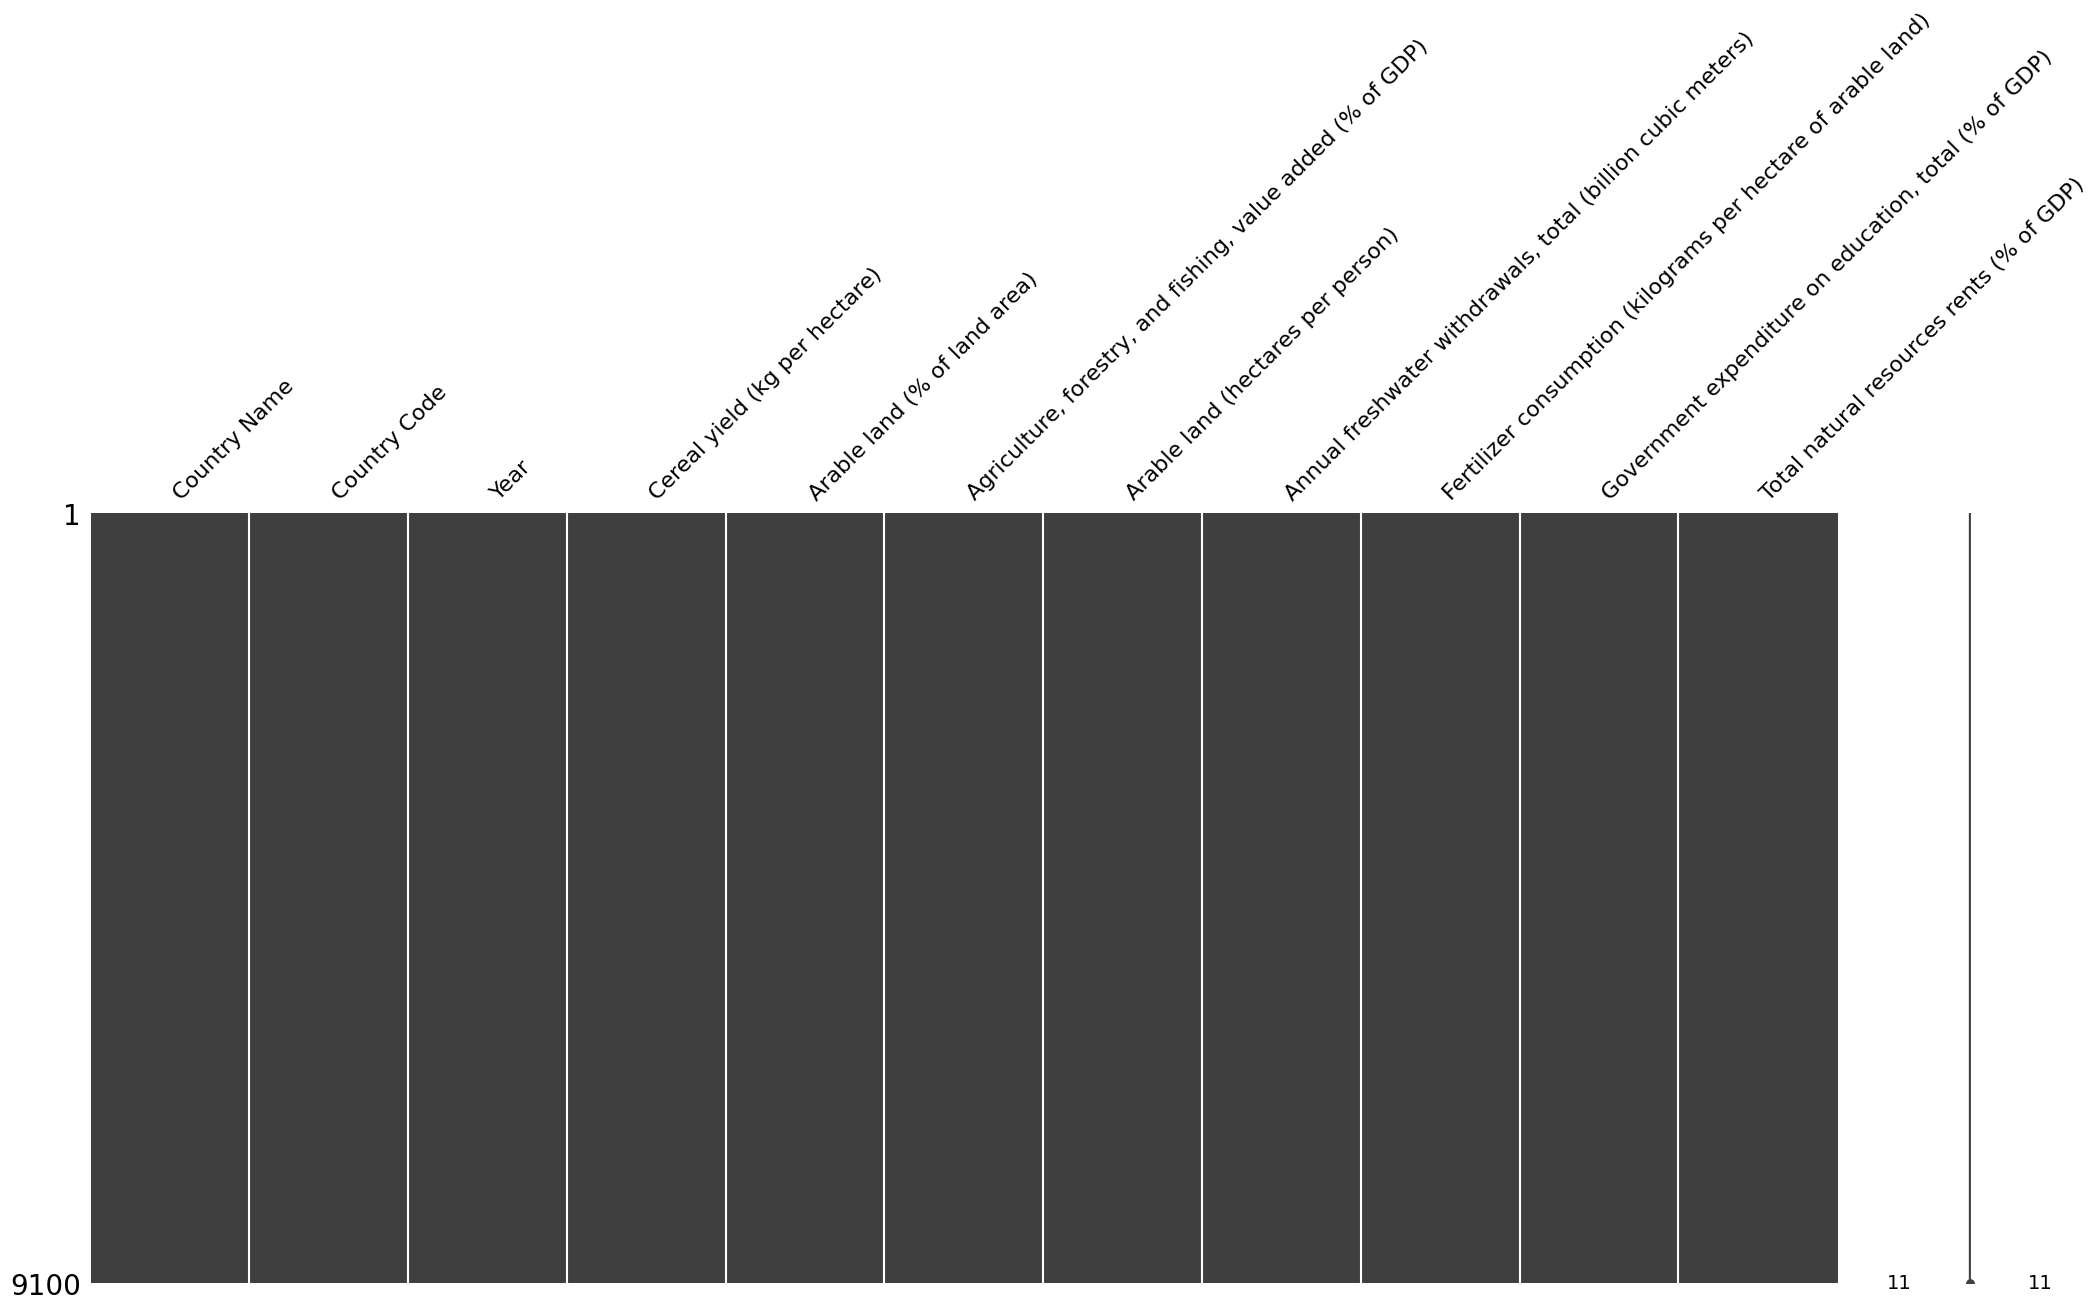

In [221]:
msno.matrix(imputed_log_df);

In [229]:
imputed_log_df.columns

Index(['Country_Name', 'Country_Code', 'Year', 'Cereal_Yield',
       'Arable_Land_Percent', 'Value_Added_AFF', 'Arable_Land_Person',
       'Freshwater_Withdrawl', 'Fertilizer', 'Education_Expenditure',
       'Natural_Resource_Rents'],
      dtype='object')

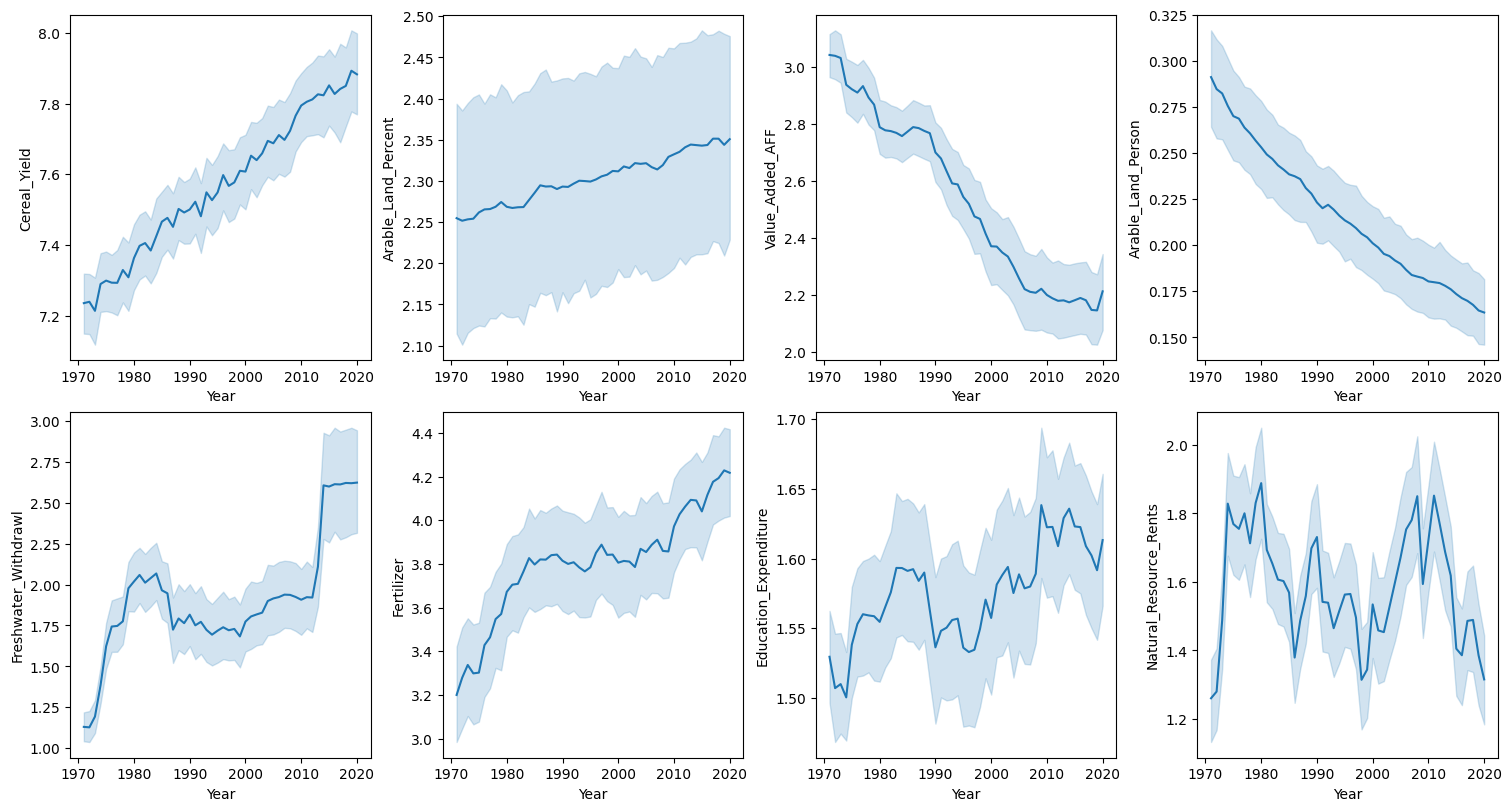

In [234]:
fig, ax = plt.subplots(2, 4, figsize = (15, 8), constrained_layout = True)

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Cereal_Yield', ax = ax[0, 0])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Arable_Land_Percent', ax = ax[0, 1])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Value_Added_AFF', ax = ax[0, 2])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Arable_Land_Person', ax = ax[0, 3])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Freshwater_Withdrawl', ax = ax[1, 0])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Fertilizer', ax = ax[1, 1])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Education_Expenditure', ax = ax[1, 2])

sns.lineplot(data = imputed_log_df, x = 'Year', y = 'Natural_Resource_Rents', ax = ax[1, 3]);

## Export this dataset for first round of modelling

In [225]:
imputed_log_df.to_parquet('../data/world_bank_variables_target.pq')